In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=(15,6)

import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf,adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from pandas.plotting import autocorrelation_plot,lag_plot

import warnings
warnings.filterwarnings('ignore')

In [84]:
df=pd.read_csv(r"C:\Users\admin\Desktop\Extra Projects\Time series-champagne sales\perrin-freres-monthly-champagne-.csv")

In [85]:
df.shape
df.columns=['Month','Sales']

In [86]:
df.loc[df['Month']=='Perrin Freres monthly champagne sales millions ?64-?72','Month']

106    Perrin Freres monthly champagne sales millions...
Name: Month, dtype: object

In [87]:
df.drop(106,inplace=True)

In [88]:
df.head(3)

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0


In [89]:
df.dropna(inplace=True)

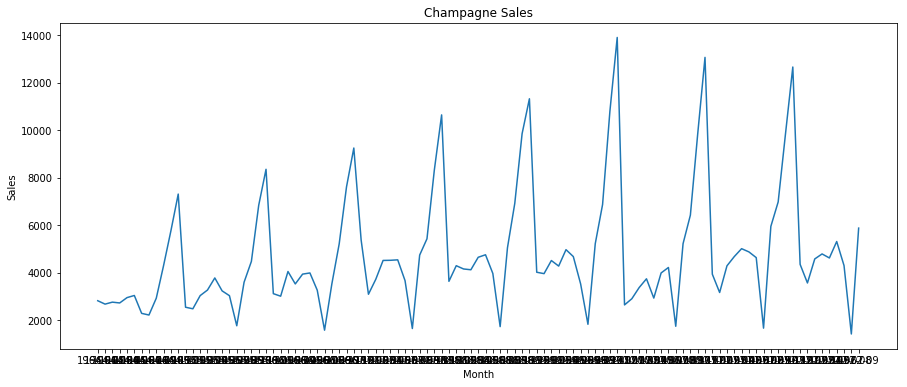

In [48]:
#Time plots

plt.plot(df['Month'],df['Sales'])
plt.xlabel("Month")
plt.ylabel("Sales")
plt.title("Champagne Sales")
plt.show()

In [52]:
# Stacked line chart
from datetime import datetime as dt
df['Month']=pd.to_datetime(df['Month'])
df['year']=df['Month'].dt.year
df['Mth']=df['Month'].dt.month
df.head(3)

,Month,Sales,year,Mth
0,1964-01-01,2815.0,1964,1
1,1964-02-01,2672.0,1964,2
2,1964-03-01,2755.0,1964,3


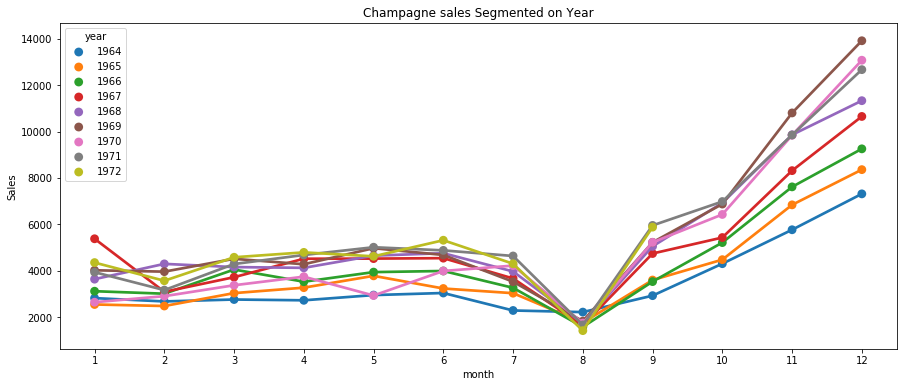

In [55]:
sns.pointplot(x=df['Mth'],y=df['Sales'],hue=df['year'])
plt.xlabel("month")
plt.ylabel("Sales")
plt.title("Champagne sales Segmented on Year")
plt.show()

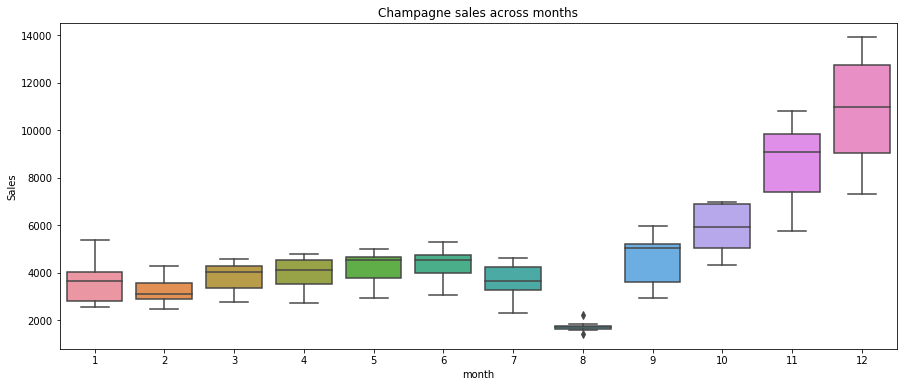

In [57]:
#Boxplot

sns.boxplot(x=df['Mth'],y=df['Sales'])
plt.xlabel("month")
plt.ylabel("Sales")
plt.title("Champagne sales across months")
plt.show()

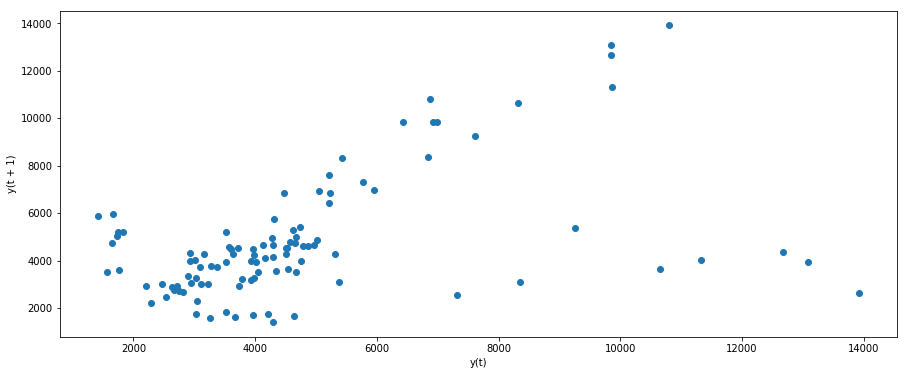

In [59]:
lag_plot(df['Sales'])

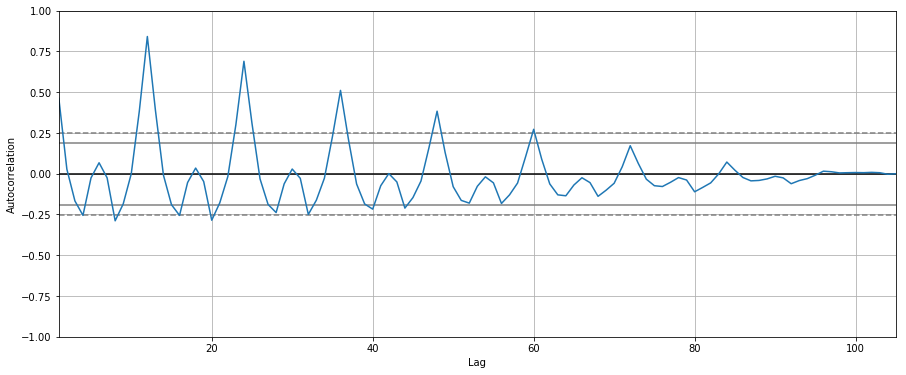

In [60]:
autocorrelation_plot(df['Sales'])

No handles with labels found to put in legend.


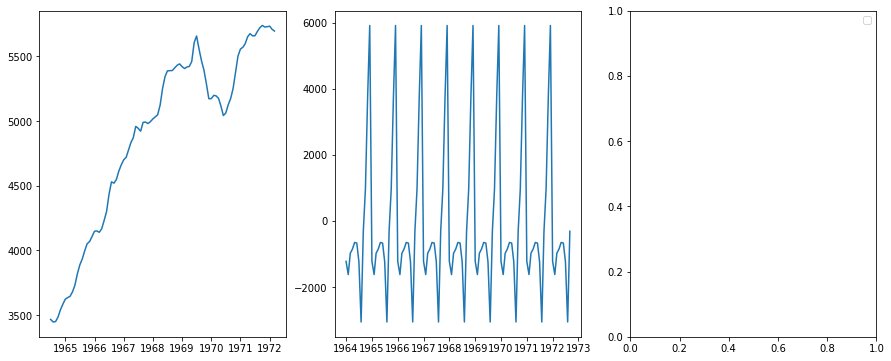

In [38]:
#Decomposing to find trend,seosonal components
df.dropna(inplace=True)
decomposed=seasonal_decompose(df['Sales'])

trend=decomposed.trend
seasonal=decomposed.seasonal
residual=decomposed.resid

plt.subplot(131)
plt.plot(trend,label='trend')
plt.subplot(132)
plt.plot(seasonal,label='seasonal')
plt.subplot(133)

#plt.subplot(residual,label='Residual')
plt.legend(loc='best')
plt.show()

In [94]:
# Transforming the dataset
#df.drop(['year','Mth'],axis=1,inplace=True)
#df.index=df['Month']
df=df[['Sales']]
df.shape

(105, 1)

In [98]:
#setting train and test data
df_log=np.log(df)


In [96]:
def test_stationarity(timeseries):
   # checking stationarity of time series data-visual
    rolmean=timeseries.rolling(window=52).mean()
    rolstd=timeseries.rolling(window=52).std()
        
    plt.plot(rolmean, c='r', label='Rolmean')
    plt.plot(rolstd,c='g',label='Rolstd')
    plt.plot(timeseries, c='b',label='Original')
    plt.legend()
    plt.title("Time series- to check stationarity")
    plt.show()
    
    #checking stationarity - by statistical test-dickey fuller test
    print("Dickey-Fuller Test")
    print("------------------",end='\n')
    test_stat,p_value,lags,nobs,critical_value,aic=adfuller(timeseries)
    print("Test Stat is {}".format(test_stat))
    print("p_value is {}".format(p_value))
    print("lags is {}".format(lags))
    print("No of obs is {}".format(nobs))
    
    for key,value in critical_value.items():
        print("Critical value-",key,critical_value[key],end='\n')
    print('')
    if p_value < 0.05:
        print("Reject null hypothesis- Data is Stationary")
    else:
        print("Accept null hypothesis- Data is non stationary")

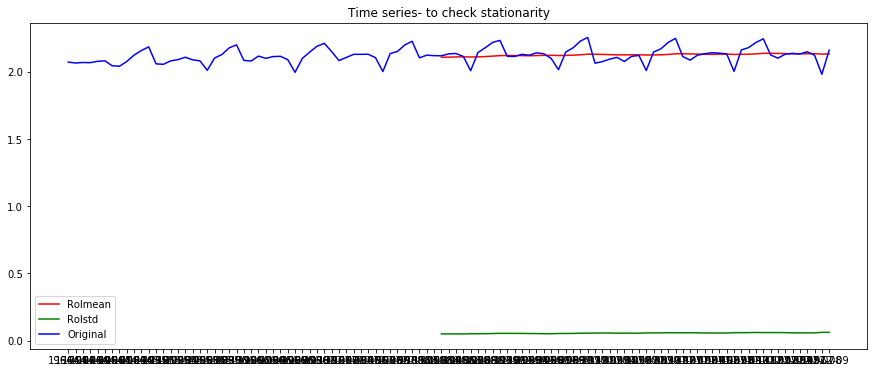

Dickey-Fuller Test
------------------
Test Stat is -2.291426408671262
p_value is 0.17474803706257053
lags is 13
No of obs is 91
Critical value- 1% -3.50434289821397
Critical value- 5% -2.8938659630479413
Critical value- 10% -2.5840147047458037

Accept null hypothesis- Data is non stationary


In [100]:
test_stationarity(df_log['Sales'])

In [103]:
#Differencing
df_log_diff=df_log.diff(1)
df_log_diff.dropna(inplace=True)

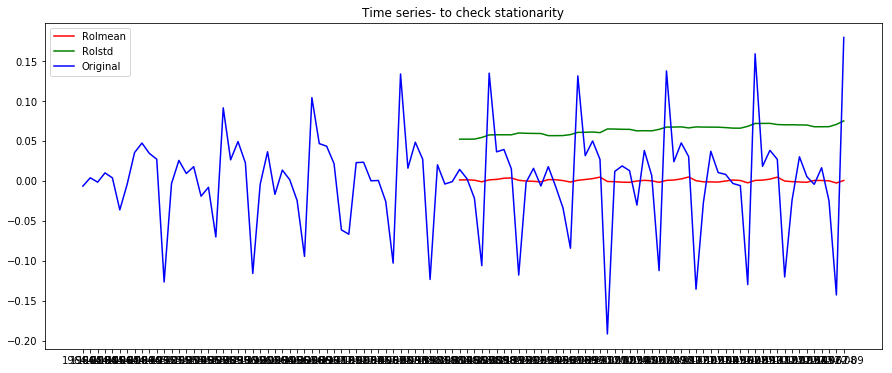

Dickey-Fuller Test
------------------
Test Stat is -4.440015140798306
p_value is 0.0002519967387270699
lags is 12
No of obs is 91
Critical value- 1% -3.50434289821397
Critical value- 5% -2.8938659630479413
Critical value- 10% -2.5840147047458037

Reject null hypothesis- Data is Stationary


In [104]:
test_stationarity(df_log_diff['Sales'])

In [105]:
#After differencing , data is now stationary. Deriving train and test data
len(df_log_diff)

104

In [138]:
#traindata=df_log[0:len(df_log_diff)-12]
#testdata=df_log[len(traindata)-12:]
traindata=df_log.values
traindata[:5]

array([[2.07225548],
       [2.06566996],
       [2.06953927],
       [2.06797034],
       [2.0779659 ]])

In [110]:
#To find p,q values
acf_value=acf(df_log_diff)
pacf_value=pacf(df_log_diff)

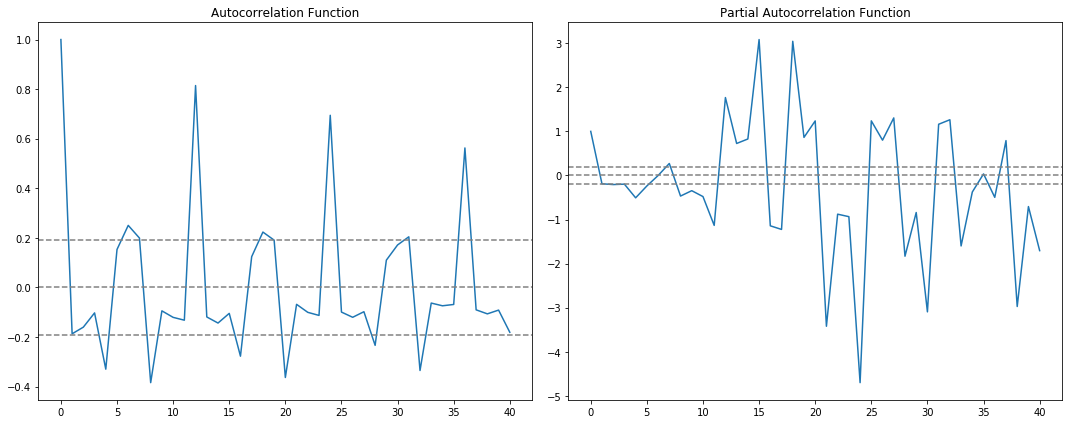

In [113]:
plt.subplot(121)
plt.plot(acf_value)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(pacf_value)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. In this case p=1 
q – The lag value where the ACF chart crosses the upper confidence interval for the first time. In this case q=1

In [139]:
model=ARIMA(traindata,[1,1,1])
model=model.fit()

In [142]:
pred=model.predict(start=1, 
    end=len(traindata))

In [145]:
pred[:5]

array([ 0.0005118 ,  0.00284494,  0.00089091,  0.00177105, -0.00310302])

In [152]:
traindata[:5]

array([[2.07225548],
       [2.06566996],
       [2.06953927],
       [2.06797034],
       [2.0779659 ]])

In [151]:
condf=pd.DataFrame()
condf['Actual']=traindata

Exception: Data must be 1-dimensional

In [126]:
df_log_diff=df_log_diff['Sales']

In [134]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                   91
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 140.470
Method:                       css-mle   S.D. of innovations              0.051
Date:                Fri, 24 Jan 2020   AIC                           -272.941
Time:                        01:05:09   BIC                           -262.897
Sample:                    02-01-1964   HQIC                          -268.889
                         - 08-01-1971                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.000      1.504      0.136      -0.000       0.001
ar.L1.D.Sales     0.3966      0.102      3.895      0.000       0.197       0.596
ma.L1.D.Sales    -0.9999      0.034    -29.283      0.000      -1.067      -0.933
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5214           +0.0000j            2.5214            0.0000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [135]:
pred.index=
#compare_df=pd.concat([df_log_diff.tail(25),pred],axis=1)
#compare_df.columns=['Actual','Predicted with AR']
#compare_df

(25, 1)

5.391529246883888


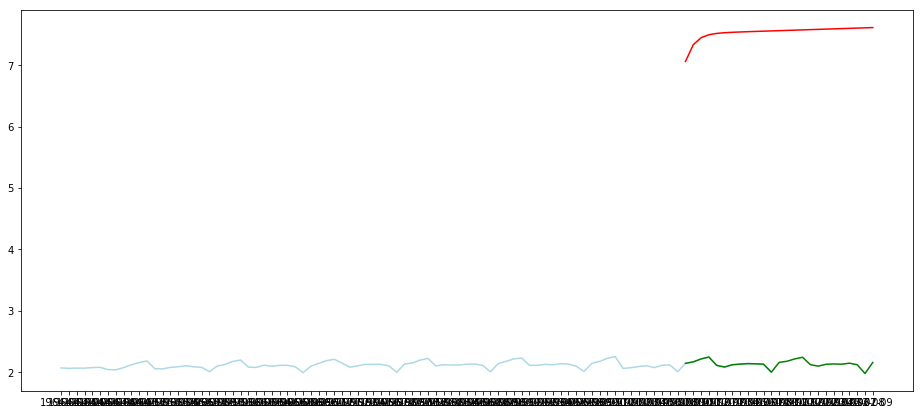

In [132]:
plt.figure(figsize=(16, 7))
plt.plot(traindata.index, traindata.values, color="lightblue")
plt.plot(testdata.index, testdata.values, color="green")

## Forecasting 
pred = pd.DataFrame(model.forecast(len(testdata))[0])
pred.columns = ["yhat"]
pred.index = testdata.index

## Converting from log to normal value
import math
pred["yhat"] = pred["yhat"].apply(lambda x: math.exp(x)-1)

## Measuring error.
from sklearn.metrics import mean_squared_error
measure = math.pow(mean_squared_error(testdata.values, pred.values), 0.5)
print(measure)
plt.plot(pred.index, pred.fillna(0).values, color="red")
plt.show()